In [1]:
# ------------------------------------------------------
# 1. Imports and setup
# ------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, log_loss, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve, brier_score_loss)
from sklearn.calibration import calibration_curve
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Libraries loaded. Ready for ML.")

Libraries loaded. Ready for ML.


In [2]:
# ------------------------------------------------------
# 2. Load data and feature engineering
# ------------------------------------------------------
# 1. Load master dataset
df = pd.read_csv('../data-processed/win_prob_training_data.csv')

# 2. Define full list (for hypothesis testing later)
all_features = [
    'pre_match_rank_diff', 'squad_age_diff', 'kickoff_hour',
    'temperature', 'apparent_temp', 'humidity', 'wind_speed',
    'score_diff', 'red_diff', 'yellow_diff', 'home_subs', 'away_subs', 
    'time_remaining',
    # The "Future" variables (safe for Analysis, invalid for ML)
    'total_shot_diff', 'total_sot_diff', 'foul_diff', 'hPossession',
    'is_extra_time', 'is_penalty_shootout'
]

target = 'target_home_win'

# 3. Define the ML features
# Specifically exclude future variables here to prevent data leakage
ml_features = [
    # Static context
    'pre_match_rank_diff', 
    'squad_age_diff', 
    'kickoff_hour',
    'temperature', 'apparent_temp', 'humidity', 'wind_speed',
    
    # Dynamic game state
    'score_diff', 
    'red_diff', 
    'yellow_diff', 
    'home_subs', 
    'away_subs',
    'time_remaining'
]

# 4. Drop rows with missing values
# Drop NaNs based on all features to ensure the hypothesis tests don't crash later
print(f"Original shape: {df.shape}")
df_clean = df.dropna(subset=all_features + [target])
print(f"Clean shape: {df_clean.shape}")

# 5. Preview correlation (using safe features only to see predictive power)
print("\n--- Correlation (Safe Features only) ---")
print(df_clean[ml_features + [target]].corr()[target].sort_values(ascending=False))

Original shape: (2304, 25)
Clean shape: (2304, 25)

--- Correlation (Safe Features only) ---
target_home_win        1.000000e+00
score_diff             5.384097e-01
pre_match_rank_diff    3.235333e-01
red_diff               1.878932e-01
yellow_diff            1.423086e-01
away_subs              8.609674e-02
temperature            4.193927e-02
apparent_temp          3.912882e-02
wind_speed             3.462331e-02
humidity               1.392194e-02
time_remaining         3.441095e-17
home_subs             -1.770946e-02
squad_age_diff        -2.887422e-02
kickoff_hour          -4.077497e-02
Name: target_home_win, dtype: float64


In [3]:
# ------------------------------------------------------
# 3. Leakage-proof split
# ------------------------------------------------------
# 1. Get unique matches
match_ids = df_clean['match_id'].unique()
train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)

# 2. Filter df based on these IDs
train_df = df_clean[df_clean['match_id'].isin(train_ids)]
test_df = df_clean[df_clean['match_id'].isin(test_ids)]

# 3. Define X and y using only safe ML List
# To ensure model never sees 'total_shots' or 'is_extra_time'
X_train = train_df[ml_features] 
y_train = train_df[target]

X_test = test_df[ml_features] 
y_test = test_df[target]

print(f"Training on {len(train_ids)} matches ({len(X_train)} rows)")
print(f"Testing on {len(test_ids)} matches ({len(X_test)} rows)")
print(f"Features used for training: {len(X_train.columns)}")

Training on 307 matches (1842 rows)
Testing on 77 matches (462 rows)
Features used for training: 13


In [4]:
# ------------------------------------------------------
# 4. Model training
# ------------------------------------------------------
# Dictionary to store  models
models = {}

# --- 1. Logistic regression (baseline) ---
# Requires scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
models['Logistic Regression'] = log_reg

# --- 2. K-nearest neighbours ---
# Must use scaled data
knn = KNeighborsClassifier(n_neighbors=15) # Safe starting point to reduce noise
knn.fit(X_train_scaled, y_train)
models['KNN'] = knn

# --- 3. Decision tree ---
# Often overfits, good for "white box" explainability
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
models['Decision Tree'] = dt

# --- 4. Random forest ---
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model

# --- 5. Gradient boosting ---
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train, y_train)
models['Gradient Boosting'] = gb_model

# --- 6. XGBoost ---
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

print(f"Trained {len(models)} models successfully.")

Trained 6 models successfully.


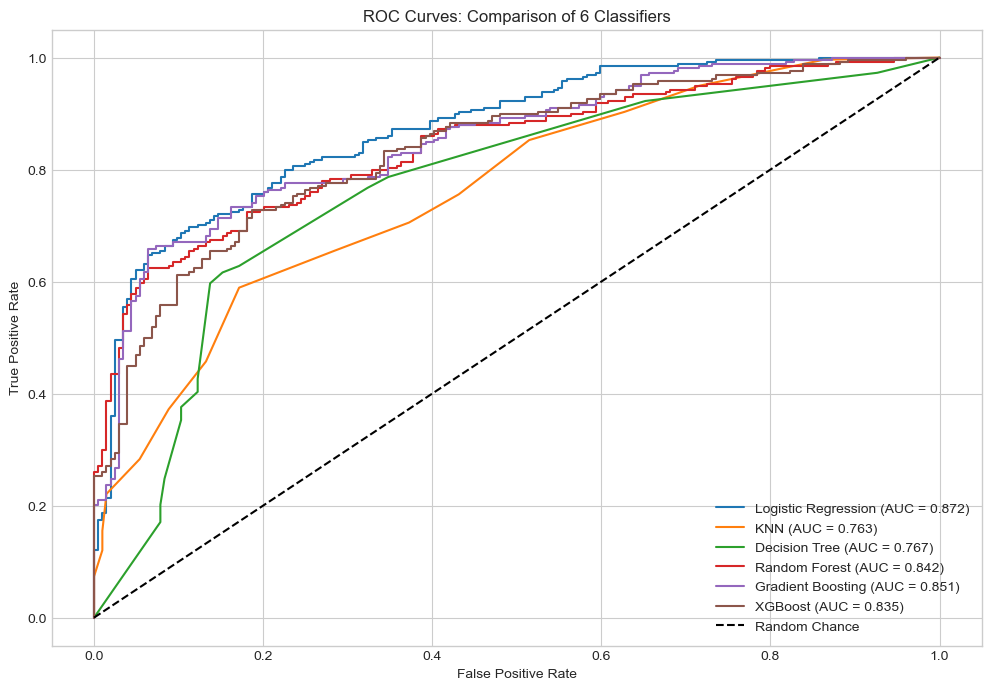


--- Model Performance Metrics ---
                 Model  Accuracy  Log Loss     AUC  Brier Score
0  Logistic Regression    0.7727    0.4769  0.8724       0.1568
4    Gradient Boosting    0.7727    0.5143  0.8510       0.1693
3        Random Forest    0.7532    0.5305  0.8415       0.1753
5              XGBoost    0.7446    0.6110  0.8353       0.1903
1                  KNN    0.6948    0.6966  0.7627       0.2168
2        Decision Tree    0.7143    2.3639  0.7675       0.2299


In [5]:
# ------------------------------------------------------
# 5. Comprehensive evaluation
# ------------------------------------------------------
results = []
plt.figure(figsize=(12, 8))

for name, model in models.items():
    # A. Handle scaling logic
    # LogReg and KNN need scaled data; trees do not
    if name in ['Logistic Regression', 'KNN']:
        X_val = X_test_scaled
    else:
        X_val = X_test
        
    # B. Predictions
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # C. Metrics
    acc = accuracy_score(y_test, y_pred)
    ll = log_loss(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    brier = brier_score_loss(y_test, y_prob)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Log Loss': ll, 
        'AUC': auc,
        'Brier Score': brier
    })
    
    # D. Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Comparison of 6 Classifiers')
plt.legend(loc='lower right')
plt.show()

# Display metrics table sorted by Brier score (best to worst)
metrics_df = pd.DataFrame(results).sort_values(by='Brier Score', ascending=True)
print("\n--- Model Performance Metrics ---")
print(metrics_df.round(4))

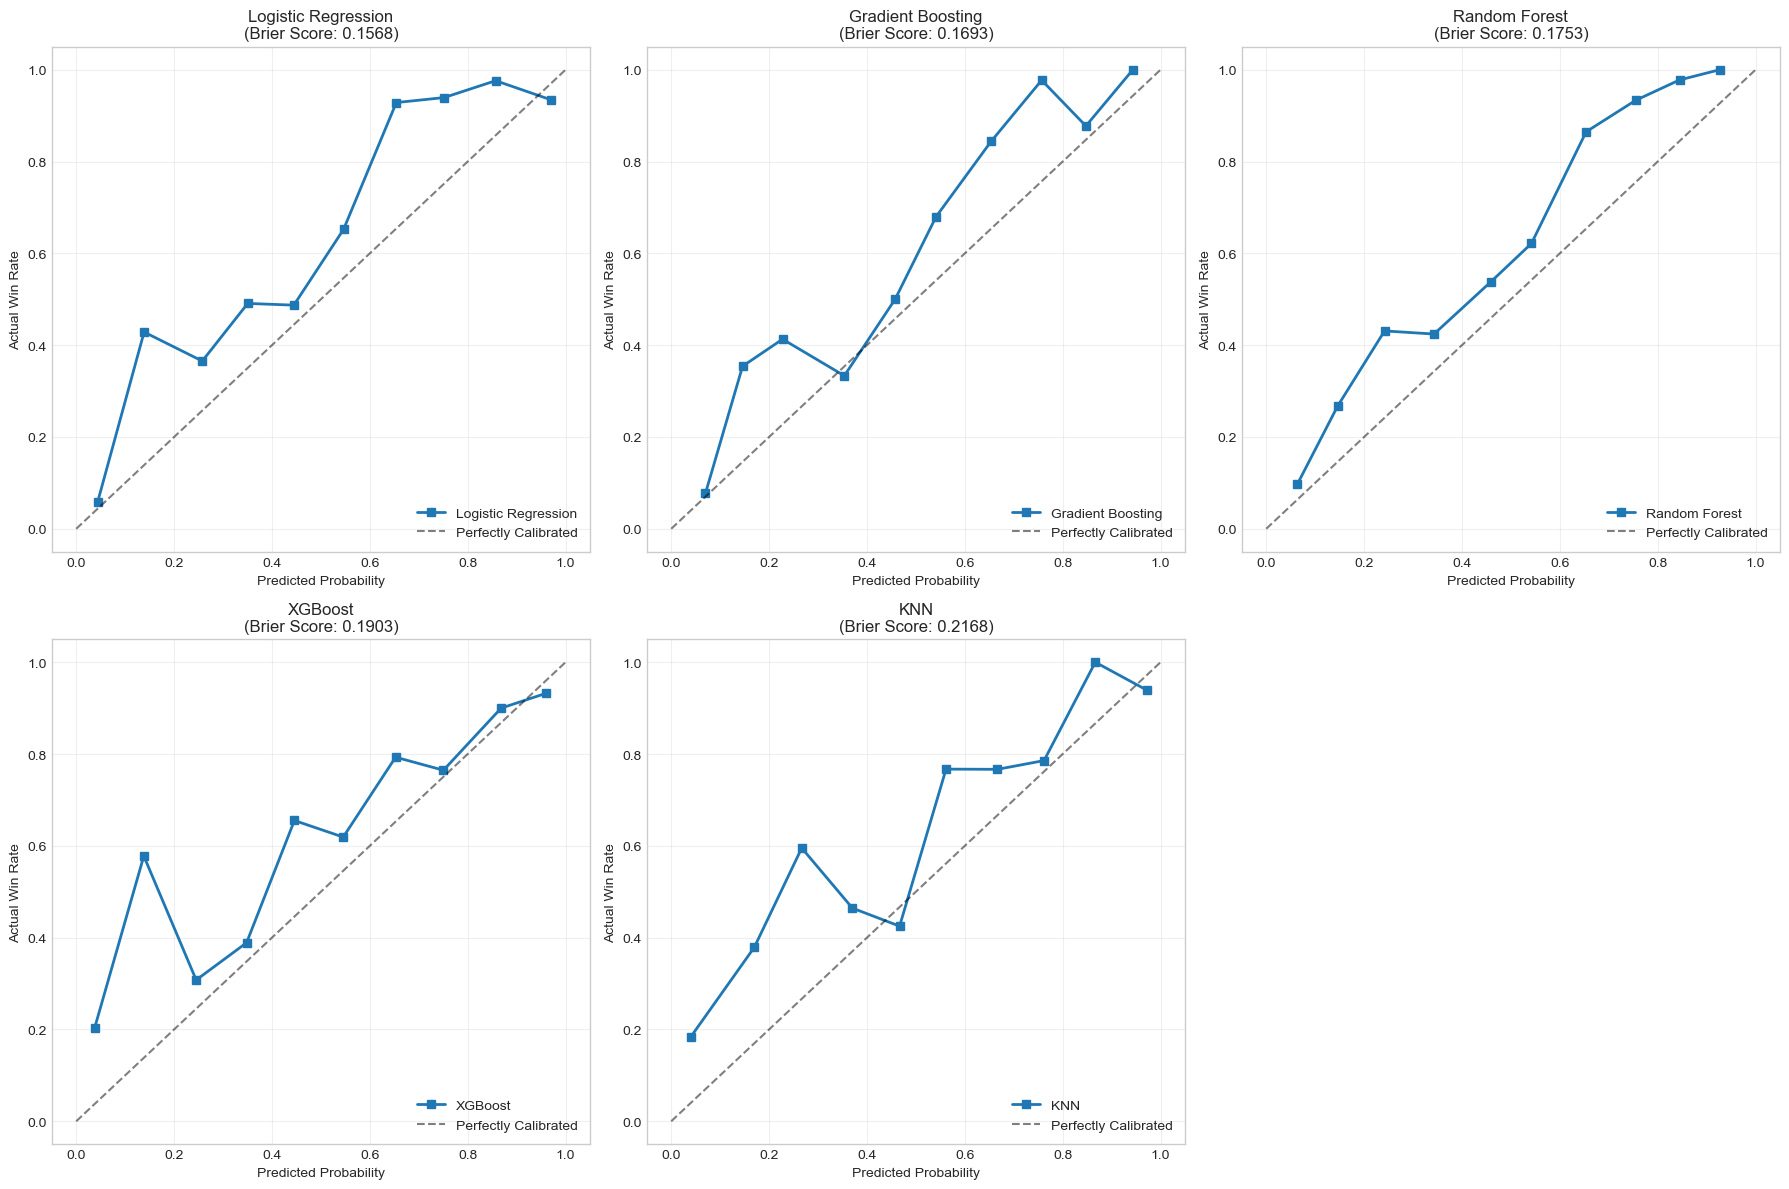

- If the blue line is below the dotted line, the model is over-confident (predicting too high win prob).
- If the blue line is above the dotted line, the model is under-confident (too conservative).
- Logistic Regression should be closest to the dotted line (lowest Brier score).


In [6]:
# ------------------------------------------------------
# 6. Probability calibration analysis
# ------------------------------------------------------
import matplotlib.gridspec as gridspec

plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 3)

# List of models to plot (skip decision tree as it doesn't output smooth probs)
models_to_plot = ['Logistic Regression', 'Gradient Boosting', 'Random Forest', 'XGBoost', 'KNN']

for i, name in enumerate(models_to_plot):
    ax = plt.subplot(gs[i])
    model = models[name]
    
    # Handle scaling logic
    if name in ['Logistic Regression', 'KNN']:
        X_val = X_test_scaled
    else:
        X_val = X_test
        
    # Get probabilities
    prob_pos = model.predict_proba(X_val)[:, 1]
    
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    
    # Plot
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", linewidth=2, color='tab:blue', label=name)
    ax.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated", alpha=0.5)
    
    # Metrics for title
    brier = brier_score_loss(y_test, prob_pos)
    
    ax.set_ylabel("Actual Win Rate")
    ax.set_xlabel("Predicted Probability")
    ax.set_title(f"{name}\n(Brier Score: {brier:.4f})")
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("- If the blue line is below the dotted line, the model is over-confident (predicting too high win prob).")
print("- If the blue line is above the dotted line, the model is under-confident (too conservative).")
print("- Logistic Regression should be closest to the dotted line (lowest Brier score).")

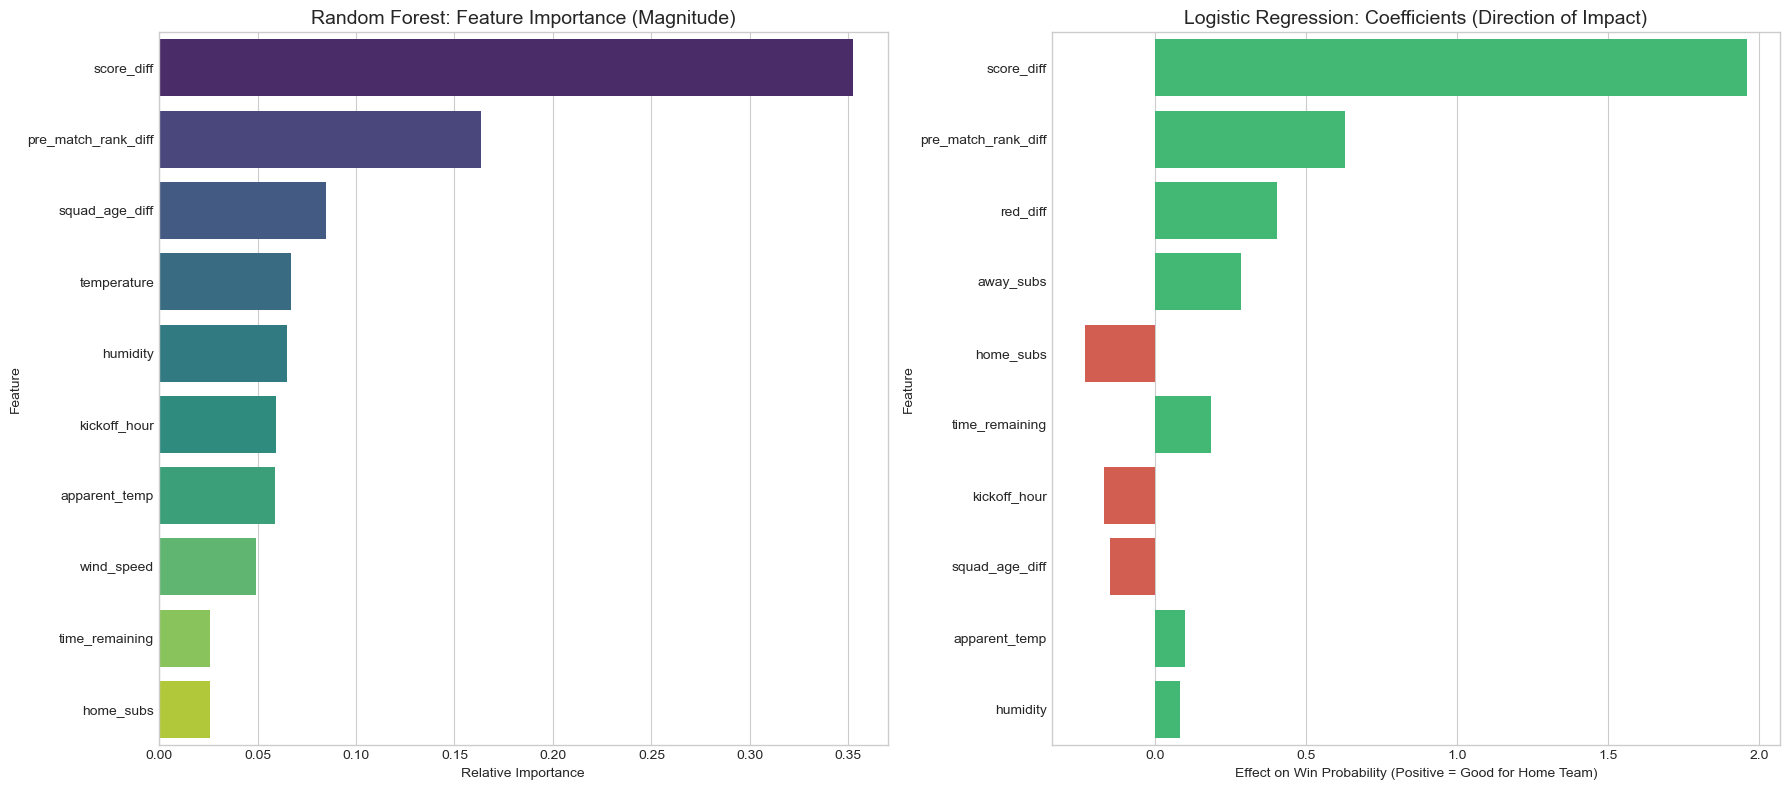

In [7]:
# ------------------------------------------------------
# 7. Dual feature importance analysis
# ------------------------------------------------------

# Setup data for plotting
feature_names = X_train.columns

# --- A. Magnitude (importance of random forest) ---
# "Which variables does the tree look at most?"
importances = models['Random Forest'].feature_importances_
rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
rf_df = rf_df.sort_values(by='Importance', ascending=False)

# --- B. Direction (logistic regression coefficients) ---
# "Does this variable make a win more likely (positive) or less likely (negative)?"
coeffs = models['Logistic Regression'].coef_[0]
log_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})
# Add absolute value for sorting, but keep original for colour
log_df['Abs_Coef'] = log_df['Coefficient'].abs()
log_df = log_df.sort_values(by='Abs_Coef', ascending=False)

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Random forest (What is important?)
sns.barplot(x='Importance', y='Feature', hue='Feature', data=rf_df.head(10), ax=axes[0], palette='viridis', legend=False)
axes[0].set_title("Random Forest: Feature Importance (Magnitude)", fontsize=14)
axes[0].set_xlabel("Relative Importance")

# Plot 2: Logistic regression (What is the effect?)
# We colour code by positive (blue) vs negative (red) impact
colours = ['#2ecc71' if c > 0 else '#e74c3c' for c in log_df.head(10)['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', hue='Feature', data=log_df.head(10), ax=axes[1], palette=colours, legend=False)
axes[1].set_title("Logistic Regression: Coefficients (Direction of Impact)", fontsize=14)
axes[1].set_xlabel("Effect on Win Probability (Positive = Good for Home Team)")

plt.tight_layout()
plt.show()

Visualising Match ID: M-2018-41


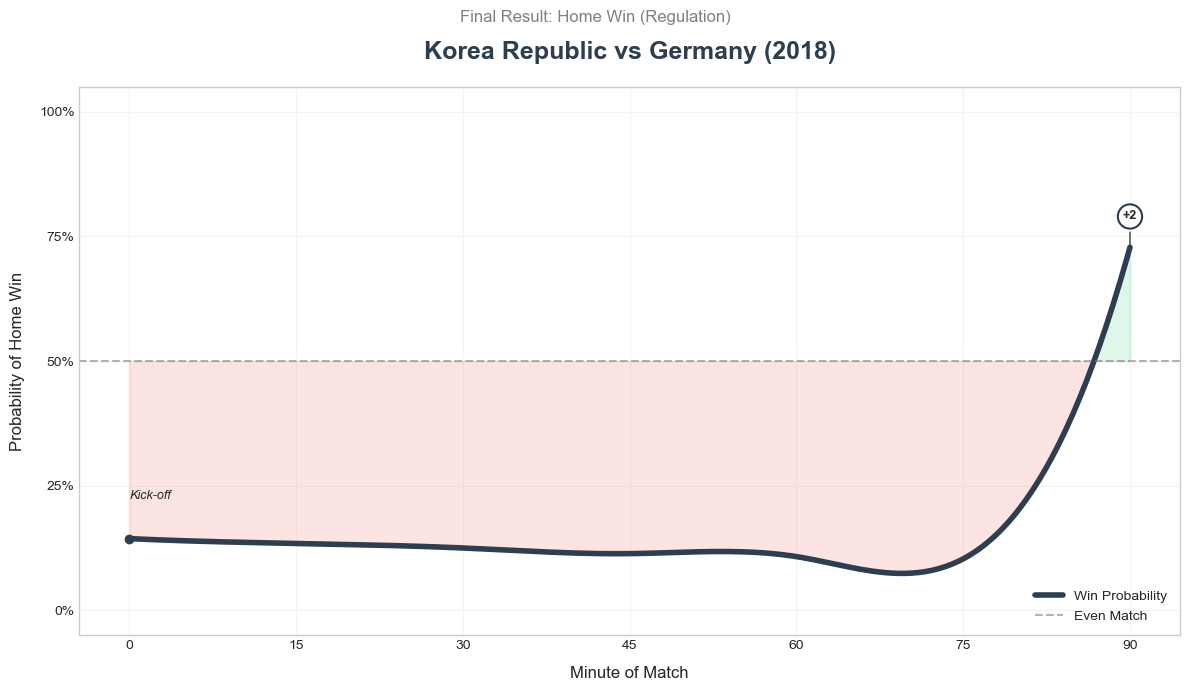

In [11]:
# ------------------------------------------------------
# 8. Visualising a match journey
# ------------------------------------------------------
from scipy.interpolate import make_interp_spline

def plot_match_prob_curve(match_id_to_plot):
    # 1. Get data and sort
    match_data = df_clean[df_clean['match_id'] == match_id_to_plot].sort_values('chunk_minute')
    
    if match_data.empty:
        print(f"Match ID {match_id_to_plot} not found.")
        return

    # Create a "Minute 0" row
    # Take the first available row (Minute 15) and reset the game state variables
    row_0 = match_data.iloc[0].copy()
    
    # Reset dynamic features to "kick-off state"
    row_0['chunk_minute'] = 0
    row_0['time_remaining'] = 90
    row_0['score_diff'] = 0
    row_0['red_diff'] = 0
    row_0['yellow_diff'] = 0
    row_0['home_subs'] = 0
    row_0['away_subs'] = 0
    
    # Add this new row to top of df
    match_data = pd.concat([pd.DataFrame([row_0]), match_data], ignore_index=True)
    # ------------------------------------------

    # 2. Prepare and predict (logistic regression)
    # Now match_data includes Minute 0
    X_match = match_data[ml_features]
    X_match_scaled = scaler.transform(X_match)
    probs = models['Logistic Regression'].predict_proba(X_match_scaled)[:, 1]
    
    # 3. Metadata
    home_team = match_data.iloc[0]['home_team_name']
    away_team = match_data.iloc[0]['away_team_name']
    tourney_id = match_data.iloc[0]['tournament_id'] 
    year = tourney_id.split('-')[1]
    # Smart title logic
    raw_match = df[df['match_id'] == match_id_to_plot].iloc[0]
    is_et = raw_match['is_extra_time'] == 1
    is_ps = raw_match['is_penalty_shootout'] == 1
    target_home_win = raw_match['target_home_win'] # 1 or 0
    
    last_chunk = match_data.iloc[-1]
    final_gd = last_chunk['score_diff']
    
    if is_ps:
        # If penalties, binary target tells us the shootout winner
        winner = "Home" if target_home_win == 1 else "Away"
        final_result = f"{winner} Win (Penalties)"
        
    elif is_et:
        # If extra-time (but no pens), target tells us the ET winner
        winner = "Home" if target_home_win == 1 else "Away"
        final_result = f"{winner} Win (Extra Time)"
        
    else:
        # Regulation Time
        if final_gd > 0:
            final_result = "Home Win (Regulation)"
        elif final_gd < 0:
            final_result = "Away Win (Regulation)"
        else:
            final_result = "Draw"

    # 4. Smoothing
    minutes = match_data['chunk_minute'].values
    # Create more points for smoothness (0 to 90)
    minutes_smooth = np.linspace(minutes.min(), minutes.max(), 300)
    
    spl = make_interp_spline(minutes, probs, k=3) 
    probs_smooth = spl(minutes_smooth)
    probs_smooth = np.clip(probs_smooth, 0, 1)

    # 5. Plotting
    plt.figure(figsize=(12, 7))
    
    # Background zones
    plt.fill_between(minutes_smooth, 0.5, probs_smooth, 
                     where=(probs_smooth >= 0.5), color='#2ecc71', alpha=0.15, interpolate=True)
    plt.fill_between(minutes_smooth, 0.5, probs_smooth, 
                     where=(probs_smooth < 0.5), color='#e74c3c', alpha=0.15, interpolate=True)

    # Line
    plt.plot(minutes_smooth, probs_smooth, linewidth=4, color='#2c3e50', label='Win Probability')
    plt.axhline(0.5, color='gray', linestyle='--', alpha=0.6, linewidth=1.5, label='Even Match')
    
    # 6. Styling
    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0], ['0%', '25%', '50%', '75%', '100%'], fontsize=10)
    plt.xticks(np.arange(0, 105, 15), fontsize=10) # Show 0, 15, 30... ticks
    plt.ylabel("Probability of Home Win", fontsize=12, labelpad=10)
    plt.xlabel("Minute of Match", fontsize=12, labelpad=10)
    
    # 7. Title
    title_text = f"{home_team} vs {away_team} ({year})"
    subtitle_text = f"Final Result: {final_result}"
    
    plt.title(title_text, fontsize=18, fontweight='bold', pad=20, color='#2c3e50')
    plt.suptitle(subtitle_text, fontsize=12, color='gray', y=0.98) 

    # 8. Annotations (goals)
    prev_score = None
    for i in range(len(match_data)):
        curr_score = match_data.iloc[i]['score_diff']
        minute = match_data.iloc[i]['chunk_minute']
        prob_val = probs[i]
        
        # Don't annotate Minute 0 unless it's distinct (usually 0)
        if minute == 0:
            # Just mark start point
            plt.scatter(minute, prob_val, color='#2c3e50', zorder=5)
            plt.text(minute, prob_val + 0.08, "Kick-off", ha='left', fontsize=9, fontstyle='italic')
            prev_score = curr_score
            continue

        # Annotate score changes
        if prev_score is None or curr_score != prev_score:
            score_text = f"{curr_score:+}"
            bbox_props = dict(boxstyle="circle,pad=0.4", fc="white", ec="#2c3e50", lw=1.5)
            
            plt.annotate(score_text, 
                         (minute, prob_val), 
                         xytext=(0, 20), textcoords='offset points',
                         ha='center', fontsize=9, fontweight='bold',
                         bbox=bbox_props,
                         arrowprops=dict(arrowstyle='-', color='#2c3e50', lw=1))
        prev_score = curr_score

    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# --- Run function ---
import random
random_match_id = random.choice(test_ids)
print(f"Visualising Match ID: {random_match_id}")
plot_match_prob_curve(random_match_id)

Visualising: Brazil vs Turkey (M-2002-10)
Visualising: England vs United States (M-2010-05)
Visualising: Belgium vs Japan (M-2018-54)
Visualising: Argentina vs France (M-2022-64)


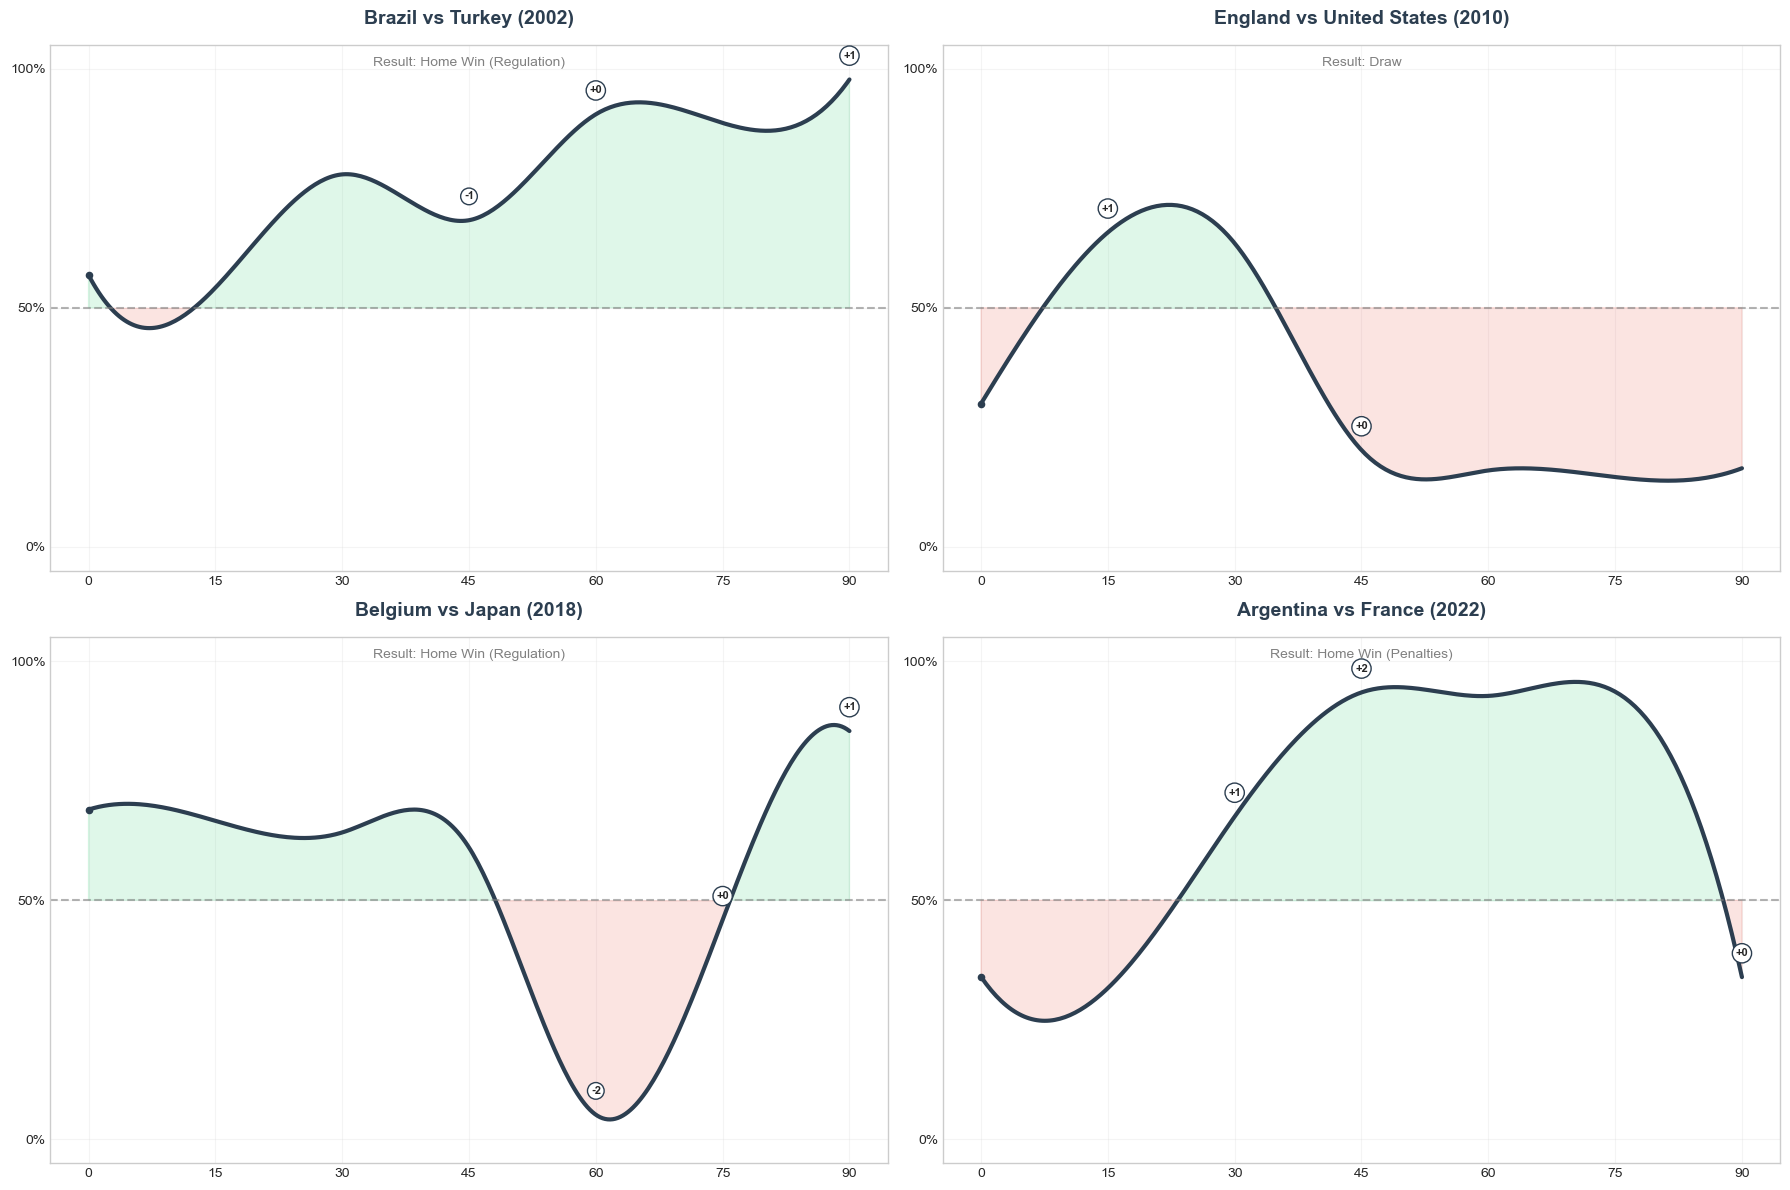

In [15]:
# ------------------------------------------------------
# 9. 2x2 Match journey grid
# ------------------------------------------------------
# --- Plotting logic ---
def plot_match_on_ax(ax, match_id, title_override=None):
    # 1. Get Data
    match_data = df_clean[df_clean['match_id'] == match_id].sort_values('chunk_minute')
    
    if match_data.empty:
        ax.text(0.5, 0.5, "Match Data Not Found", ha='center', va='center')
        return

    # Minute 0 simulation
    row_0 = match_data.iloc[0].copy()
    row_0['chunk_minute'] = 0
    row_0['time_remaining'] = 90
    row_0['score_diff'] = 0
    for col in ['red_diff', 'yellow_diff', 'home_subs', 'away_subs']:
        row_0[col] = 0
    match_data = pd.concat([pd.DataFrame([row_0]), match_data], ignore_index=True)

    # 2. Predict
    X_match = match_data[ml_features]
    X_match_scaled = scaler.transform(X_match)
    probs = models['Logistic Regression'].predict_proba(X_match_scaled)[:, 1]

    # 3. Metadata and smart title
    home = match_data.iloc[0]['home_team_name']
    away = match_data.iloc[0]['away_team_name']
    year = match_data.iloc[0]['tournament_id'].split('-')[1]
    
    raw_match = df[df['match_id'] == match_id].iloc[0]
    is_et = raw_match['is_extra_time'] == 1
    is_ps = raw_match['is_penalty_shootout'] == 1
    target_home_win = raw_match['target_home_win']
    last_chunk = match_data.iloc[-1]
    final_gd = last_chunk['score_diff']
    
    # --- Result logic ---
    if is_ps:
        # Manual override for known matches where target=0 due to draw
        ps_winners = {
            "M-2022-64": "Home", # Argentina (Home) vs France
            "M-2006-64": "Home", # Italy (Home) vs France
            "M-1994-52": "Home", # Brazil (Home) vs Italy
        }
        
        if match_id in ps_winners:
            winner = ps_winners[match_id]
        else:
            # Fallback to target variable
            winner = "Home" if target_home_win == 1 else "Away"
            
        res_text = f"{winner} Win (Penalties)"
        
    elif is_et:
        winner = "Home" if target_home_win == 1 else "Away"
        res_text = f"{winner} Win (Extra Time)"
    else:
        if final_gd > 0: res_text = "Home Win (Regulation)"
        elif final_gd < 0: res_text = "Away Win (Regulation)"
        else: res_text = "Draw"

    # 4. Smoothing
    minutes = match_data['chunk_minute'].values
    minutes_smooth = np.linspace(minutes.min(), minutes.max(), 300)
    spl = make_interp_spline(minutes, probs, k=3) 
    probs_smooth = np.clip(spl(minutes_smooth), 0, 1)

    # 5. Plotting on the specific AX
    # Zones
    ax.fill_between(minutes_smooth, 0.5, probs_smooth, where=(probs_smooth >= 0.5), color='#2ecc71', alpha=0.15, interpolate=True)
    ax.fill_between(minutes_smooth, 0.5, probs_smooth, where=(probs_smooth < 0.5), color='#e74c3c', alpha=0.15, interpolate=True)

    # Line
    ax.plot(minutes_smooth, probs_smooth, linewidth=3, color='#2c3e50')
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.6)
    
    # Axis Styling
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_yticklabels(['0%', '50%', '100%'])
    ax.set_xticks(np.arange(0, 105, 15))
    ax.grid(True, alpha=0.2)
    
    # Titles
    main_title = f"{home} vs {away} ({year})"
    ax.set_title(main_title, fontsize=14, fontweight='bold', pad=15, color='#2c3e50')
    ax.text(0.5, 0.96, f"Result: {res_text}", transform=ax.transAxes, ha='center', color='gray', fontsize=10)

    # Annotations
    prev_score = None
    for i in range(len(match_data)):
        curr_score = match_data.iloc[i]['score_diff']
        minute = match_data.iloc[i]['chunk_minute']
        prob = probs[i]
        
        if minute == 0:
            ax.scatter(minute, prob, color='#2c3e50', s=20)
            prev_score = curr_score
            continue
            
        if prev_score is None or curr_score != prev_score:
            score_text = f"{curr_score:+}"
            bbox = dict(boxstyle="circle,pad=0.3", fc="white", ec="#2c3e50")
            ax.annotate(score_text, (minute, prob), xytext=(0, 15), textcoords='offset points', ha='center', bbox=bbox, fontsize=8, fontweight='bold')
        prev_score = curr_score

# --- Choose 4 matches to visualise ---
def get_match_id(home, away, year):
    # Search for the match
    matches = df[
        (df['home_team_name'] == home) & 
        (df['away_team_name'] == away) & 
        (df['tournament_id'].str.contains(year))
    ]
    if len(matches) > 0:
        return matches.iloc[0]['match_id']
    else:
        # Try swapping home/away
        matches_swap = df[
            (df['home_team_name'] == away) & 
            (df['away_team_name'] == home) & 
            (df['tournament_id'].str.contains(year))
        ]
        if len(matches_swap) > 0:
            return matches_swap.iloc[0]['match_id']
    return None

target_matches = [
    {"home": "Brazil", "away": "Turkey", "year": "2002"},
    {"home": "England", "away": "United States", "year": "2010"},
    {"home": "Belgium", "away": "Japan", "year": "2018"},
    {"home": "Argentina", "away": "France", "year": "2022"}
]

# --- Generate grid ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, target in enumerate(target_matches):
    # 1. Find match ID
    m_id = get_match_id(target['home'], target['away'], target['year'])
    
    # 2. Plot on specific subplot (axes[i])
    if m_id:
        print(f"Visualising: {target['home']} vs {target['away']} ({m_id})")
        plot_match_on_ax(axes[i], m_id)
    else:
        axes[i].text(0.5, 0.5, "Match Not Found", ha='center')

plt.tight_layout()
plt.show()

In [32]:
# ------------------------------------------------------
# 10. Hypothesis lab setup
# ------------------------------------------------------
import statsmodels.formula.api as smf

print("--- Hypothesis testing lab ---")
print("Using Statsmodels for statistical inference.")

# 1. Load full-chunk dataset (15-min intervals)
# Use this for hypotheses involving time-varying traits (e.g. score_diff, red_diff)
stat_df = pd.read_csv('../data-processed/hypothesis_data.csv')

# Add "late game" indicator for interactions (Minutes 75 and 90)
stat_df['is_late_game'] = stat_df['chunk_minute'].apply(lambda x: 1 if x >= 75 else 0)

# 2. Create a match-level df (1 row per match)
# Use this for hypotheses involving game totals
# Drop duplicates to ensure we don't count the same match 6 times
match_df = stat_df.drop_duplicates(subset=['match_id']).copy()

print(f"Data Loaded Successfully:")
print(f"- stat_df (Chunk-Level): {len(stat_df)} rows. Use for time interactions.")
print(f"- match_df (Match-Level): {len(match_df)} rows. Use for game totals.")

--- Hypothesis testing lab ---
Using Statsmodels for statistical inference.
Data Loaded Successfully:
- stat_df (Chunk-Level): 2304 rows. Use for time interactions.
- match_df (Match-Level): 384 rows. Use for game totals.


In [38]:
# ------------------------------------------------------
# 11. Kick-off time and heat
# ------------------------------------------------------

# --- H1: Kick-off Time & Possession/Shots ---
print("\n[TEST H1] Kick-off Hour vs. Possession & Shot Volume")
print("Hypothesis: Late games have lower possession dominance and fewer total shots.")

# Model 1.1: Possession
model_h1_poss = smf.ols('hPossession ~ kickoff_hour + temperature + pre_match_rank_diff', data=match_df).fit()
print("\n--- H1.1: Effect on Possession ---")
print(model_h1_poss.summary().tables[1])

# Model 1.2: Total Shot Volume
model_h1_shots = smf.ols('game_total_shots ~ kickoff_hour + temperature + pre_match_rank_diff', data=match_df).fit()
print("\n--- H1.2: Effect on Total Shots ---")
print(model_h1_shots.summary().tables[1])


# --- H2: Heat & Attacking Efficiency ---
print("\n \n[TEST H2] Heat vs. Shot Efficiency")
print("Hypothesis: High heat reduces accuracy (SoT per shot).")

# We model Total SoT controlled by Total Shots
model_h2 = smf.ols('game_total_sot ~ game_total_shots + apparent_temp + pre_match_rank_diff', data=match_df).fit()

print("\n--- H2: Effect of Heat on Overall Match Efficiency ---")
print(model_h2.summary().tables[1])


[TEST H1] Kick-off Hour vs. Possession & Shot Volume
Hypothesis: Late games have lower possession dominance and fewer total shots.

--- H1.1: Effect on Possession ---
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              55.9428      3.531     15.843      0.000      49.000      62.886
kickoff_hour           -0.3694      0.151     -2.448      0.015      -0.666      -0.073
temperature             0.0453      0.075      0.602      0.548      -0.103       0.193
pre_match_rank_diff     0.1461      0.015      9.512      0.000       0.116       0.176

--- H1.2: Effect on Total Shots ---
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              27.7026      3.133      8.843      0.000      21.543      33.862
kic

In [39]:
# ------------------------------------------------------
# 12. Humidity and wind effects
# ------------------------------------------------------

# --- H3: Humidity & Yellow Cards ---
print("\n[TEST H3] Humidity vs. Total Yellow Cards")
print("Hypothesis: Higher humidity increases total yellow cards.")
print("Poisson regression on counts")

# Poisson Regression for Count Data (Total Yellows)
# Controls: Total Fouls (games with more fouls naturally have more cards)
model_h3 = smf.poisson('game_total_yellows ~ humidity + game_total_fouls', data=match_df).fit(disp=0)

print("\n--- H3: Effect of Humidity on Total Yellows ---")
print(model_h3.summary().tables[1])


# --- H4: Wind & Possession/Shots ---
print("\n \n[TEST H4] Wind vs. Possession & Shot Volume")
print("Hypothesis: Wind affects possession control but not shot volume.")

# Test 4.1: Possession
model_h4_poss = smf.ols('hPossession ~ wind_speed + pre_match_rank_diff', data=match_df).fit()
print("\n--- H4.1: Effect of Wind on Possession ---")
print(model_h4_poss.summary().tables[1])

# Test 4.2: Shot Volume
model_h4_shots = smf.ols('game_total_shots ~ wind_speed + pre_match_rank_diff', data=match_df).fit()
print("\n--- H4.2: Effect of Wind on Total Shots ---")
print(model_h4_shots.summary().tables[1])


[TEST H3] Humidity vs. Total Yellow Cards
Hypothesis: Higher humidity increases total yellow cards.
Poisson regression on counts

--- H3: Effect of Humidity on Total Yellows ---
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.4817      0.446     -5.560      0.000      -3.357      -1.607
humidity             0.0028      0.005      0.600      0.549      -0.006       0.012
game_total_fouls     0.0364      0.010      3.469      0.001       0.016       0.057

 
[TEST H4] Wind vs. Possession & Shot Volume
Hypothesis: Wind affects possession control but not shot volume.

--- H4.1: Effect of Wind on Possession ---
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              49.3194      0.810     60.874      0.000 

In [40]:
# ------------------------------------------------------
# 13. Time-decay and age effects
# ------------------------------------------------------

# --- H5: FIFA Ranking Gap Decay ---
print("\n[TEST H5] Ranking Difference Power over Time")
print("Hypothesis: The predictive power of ranking difference declines as the match progresses.")

# Interaction: rank_diff * chunk_minute
# If the interaction coefficient is negative (opposite to rank_diff), the effect decays.
model_h5 = smf.ols('score_diff ~ pre_match_rank_diff * chunk_minute', data=stat_df).fit()

print("\n--- H5: Interaction of Rank Diff x Time ---")
print(model_h5.summary().tables[1])


# --- H6: Age & Late Game Stamina ---
print("\n \n[TEST H6] Age Difference & Late Game Advantage")
print("Hypothesis: Younger teams gain advantage (Score Diff) in the final 30 minutes.")

# Variable: squad_age_diff = Home Age - Away Age
# High (+) Age Diff = Home is Older. Low (-) Age Diff = Home is Younger.
# Interaction: squad_age_diff * is_late_game
# Hypothesis check: If younger teams dominate late, we expect Older Home Teams (High Diff)
# to perform worse late. So we look for a negative interaction coefficient.

model_h6 = smf.ols('score_diff ~ squad_age_diff * is_late_game + pre_match_rank_diff', data=stat_df).fit()

print("\n--- H6: Interaction of Age Diff x Late Game ---")
print(model_h6.summary().tables[1])


[TEST H5] Ranking Difference Power over Time
Hypothesis: The predictive power of ranking difference declines as the match progresses.

--- H5: Interaction of Rank Diff x Time ---
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.0126      0.056     -0.225      0.822      -0.122       0.097
pre_match_rank_diff                 -0.0010      0.002     -0.464      0.643      -0.005       0.003
chunk_minute                         0.0013      0.001      1.316      0.188      -0.001       0.003
pre_match_rank_diff:chunk_minute     0.0003   3.73e-05      8.285      0.000       0.000       0.000

 
[TEST H6] Age Difference & Late Game Advantage
Hypothesis: Younger teams gain advantage (Score Diff) in the final 30 minutes.

--- H6: Interaction of Age Diff x Late Game ---
                                  co

In [41]:
# ------------------------------------------------------
# 14. Age effects on substitutions
# ------------------------------------------------------

# --- H7: Age Heterogeneity & Substitution Frequency ---
print("\n[TEST H7] Age Difference vs. Substitution Strategy")
print("Hypothesis: Older teams make more substitutions (managing fatigue).")

# 1. Need final substitution counts (minute 90/end)
# Keep='last' to grab the end-of-match state
match_end_df = stat_df.drop_duplicates(subset=['match_id'], keep='last').copy()

# 2. Create target: substitution difference (Home - Away)
# Hypothesis Logic: If Home is Older (high age diff) -> Expect Home to sub more (high sub diff)
# Expect a positive coefficient
match_end_df['sub_diff'] = match_end_df['home_subs'] - match_end_df['away_subs']

# 3. Model
# Control for extra time because matches with ET allow more substitutions (often +1).
model_h7 = smf.ols('sub_diff ~ squad_age_diff + is_extra_time', data=match_end_df).fit()

print("\n--- H7: Effect of Age Difference on Substitution Diff ---")
print(model_h7.summary().tables[1])


[TEST H7] Age Difference vs. Substitution Strategy
Hypothesis: Older teams make more substitutions (managing fatigue).

--- H7: Effect of Age Difference on Substitution Diff ---
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0284      0.038     -0.754      0.451      -0.102       0.046
squad_age_diff     0.0187      0.018      1.031      0.303      -0.017       0.054
is_extra_time      0.0300      0.128      0.234      0.815      -0.222       0.282


In [44]:
# ------------------------------------------------------
# 15. In-match dynamics (predictive power & causality)
# ------------------------------------------------------
import statsmodels.formula.api as smf

# --- H8: SoT vs. Possession Importance ---
print("\n[TEST H8] Predictor Comparison: SoT Diff vs. Possession Diff")
print("Hypothesis: Shots on target predict Goal Diff better than possession.")
print("(Standardised Coefficients)")

# 1. Standardise variables to compare coefficients (Z-scores)
cols_to_std = ['score_diff', 'total_sot_diff', 'hPossession']
match_df_std = match_df.copy()

for col in cols_to_std:
    match_df_std[col + '_z'] = (match_df_std[col] - match_df_std[col].mean()) / match_df_std[col].std()

# 2. Model: Score Diff ~ SoT Diff + Possession
model_h8 = smf.ols('score_diff_z ~ total_sot_diff_z + hPossession_z', data=match_df_std).fit()

print("\n--- H8: Standardised Regression Coefficients ---")
print(model_h8.summary().tables[1])
print("Note: Compare absolute value of 'coef' to judge predictive strength.")


# --- H9: Fouls as a symptom (Granger causality check) ---
print("\n \n[TEST H9] Lagged Regression: Do Trailing Teams Foul More?")
print("Hypothesis: Previous Score Diff predicts current Foul Diff (teams foul when losing).")
print("Data Level: 15-min chunks (lagged)")

# 1. Create lagged variable (score at previous chunk)
# Group by Match ID so we don't shift data from Match A to Match B
stat_df['prev_score_diff'] = stat_df.groupby('match_id')['score_diff'].shift(1)

# 2. Model: Current Foul Diff ~ Previous Score Diff
# We drop NaNs (the first chunk of every match has no "previous" chunk)
model_h9 = smf.ols('foul_diff ~ prev_score_diff + is_late_game', data=stat_df.dropna(subset=['prev_score_diff'])).fit()

print("\n--- H9: Effect of Past Score on Current Fouls ---")
print(model_h9.summary().tables[1])


# --- H10: Asymmetric Impact of Early Cards ---
print("\n \n[TEST H10] Early Yellow Cards vs. Attacking Output")
print("Hypothesis: Early yellow cards reduce total match shot difference.")

# 1. Define "early": state at minute 30
early_state = stat_df[stat_df['chunk_minute'] == 30][['match_id', 'yellow_diff']].rename(columns={'yellow_diff': 'early_yellow_diff'})

# 2. Merge into match totals
match_df_h10 = pd.merge(match_df, early_state, on='match_id', how='left')

# 3. Fill NA 
match_df_h10['early_yellow_diff'] = match_df_h10['early_yellow_diff'].fillna(0)

# 4. Model: Final Shot Diff ~ Early Yellow Diff
# Variable Logic: yellow_diff is (Away - Home). 
# If Home gets early card, yellow_diff becomes -1. 
# We test if this shifts total_shot_diff (Home - Away).
model_h10 = smf.ols('total_shot_diff ~ early_yellow_diff + pre_match_rank_diff', data=match_df_h10).fit()

print("\n--- H10: Effect of Early Yellow Diff on Final Shot Diff ---")
print(model_h10.summary().tables[1])


[TEST H8] Predictor Comparison: SoT Diff vs. Possession Diff
Hypothesis: Shots on target predict Goal Diff better than possession.
(Standardised Coefficients)

--- H8: Standardised Regression Coefficients ---
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.204e-17      0.050   1.03e-15      1.000      -0.099       0.099
total_sot_diff_z     0.1862      0.056      3.350      0.001       0.077       0.295
hPossession_z       -0.0716      0.056     -1.288      0.199      -0.181       0.038
Note: Compare absolute value of 'coef' to judge predictive strength.

 
[TEST H9] Lagged Regression: Do Trailing Teams Foul More?
Hypothesis: Previous Score Diff predicts current Foul Diff (teams foul when losing).
Data Level: 15-min chunks (lagged)

--- H9: Effect of Past Score on Current Fouls ---
                      coef    std err          t      P>|t|     

In [48]:
# ------------------------------------------------------
# 16. Time structure and high-stakes outcomes
# ------------------------------------------------------
import statsmodels.api as sm

# --- H11: Game State Volatility (Sensitivity over Time) ---
print("\n[TEST H11] Interaction: Score Difference * Time on Win Probability")
print("Hypothesis: The predictive power of a goal lead increases as time runs out.")
print("Data Level: 15-min chunks (logistic regression)")

# We use 'bfgs' method to avoid convergence issues
model_h11 = smf.logit('target_home_win ~ score_diff * chunk_minute + pre_match_rank_diff', data=stat_df).fit(method='bfgs', maxiter=100, disp=0)

print("\n--- H11: Win Probability Sensitivity over Time ---")
print(model_h11.summary().tables[1])


# --- H12: Discipline and Extra-Time/Penalties
print("\n \n[TEST H12] Do Contentious Games Last Longer?")
print("Hypothesis: High foul counts (disruption) increase the probability of extra time and penalty shootouts.")
print("Data Level: Match (Logistic Regression)")

# Test 12.1: Does foul volume predict extra time?
# Control for Rank Diff because evenly matched teams naturally draw more often.
model_h12_et = smf.logit('is_extra_time ~ game_total_fouls + pre_match_rank_diff', data=match_df).fit(disp=0)

print("\n--- H12.1: Effect of Total Fouls on Extra Time Probability ---")
print(model_h12_et.summary().tables[1])

# Test 12.2: Does foul volume predict penalty shootouts?
model_h12_pen = smf.logit('is_penalty_shootout ~ game_total_fouls + pre_match_rank_diff', data=match_df).fit(disp=0)

print("\n--- H12.2: Effect of Total Fouls on Penalty Shootout Probability ---")
print(model_h12_pen.summary().tables[1])


[TEST H11] Interaction: Score Difference * Time on Win Probability
Hypothesis: The predictive power of a goal lead increases as time runs out.
Data Level: 15-min chunks (logistic regression)

--- H11: Win Probability Sensitivity over Time ---
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.1108      0.114     -0.968      0.333      -0.335       0.114
score_diff                 -0.1437      0.199     -0.724      0.469      -0.533       0.245
chunk_minute               -0.0129      0.002     -5.360      0.000      -0.018      -0.008
score_diff:chunk_minute     0.0369      0.004      8.998      0.000       0.029       0.045
pre_match_rank_diff         0.0221      0.002      9.111      0.000       0.017       0.027

 
[TEST H12] Do Contentious Games Last Longer?
Hypothesis: High foul counts (disruption) increase the probabili